In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

from sklearn.impute import KNNImputer

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data PreProcessing and Data Quality issues

## a) Read in HR Employee Attrition CSV

In [3]:
df = pd.read_csv('HR_Employee_Attrition.csv')
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1.0,2,Life Sciences,1.0,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8.0,1,Life Sciences,1.0,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2.0,2,Other,1.0,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3.0,4,Life Sciences,1.0,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2.0,1,Medical,1.0,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23.0,2,Medical,1.0,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6.0,1,Medical,1.0,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4.0,3,Life Sciences,1.0,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2.0,3,Medical,1.0,2065,...,4,80,0,17,3,2,9,6,0,8


## b) Drop uninformative columns

- These are columns that consist of a single value only or do not appear to have any significance to attrition. The rows for employees of ages 18 had corresponding 'Over18' entries as 'Y'. These should have in fact been labelled as 'N' as these individuals are 18 not over 18. However, as the 'Over18' columnn was deemed as uninformative and is to be dropped, correcting this mistake was not necessary.

In [4]:
df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours' ], axis=1)
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1.0,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8.0,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2.0,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3.0,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2.0,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23.0,2,Medical,3,Male,...,3,3,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6.0,1,Medical,4,Male,...,3,1,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4.0,3,Life Sciences,2,Male,...,4,2,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2.0,3,Medical,4,Male,...,3,4,0,17,3,2,9,6,0,8


The remainder columns are assumed to be relavant. We will conserve the order of these columns in the variable column_order

In [5]:
column_order = df.columns

## c) Identify the columns that contain null values and Impute null values

In [6]:
null_count = df.isnull().sum()
null_count[null_count > 0]

DistanceFromHome      2
Gender                1
HourlyRate            2
MonthlyIncome         2
NumCompaniesWorked    1
dtype: int64

In [7]:
df[df.isna().any(axis=1)][['DistanceFromHome', 'Gender', 'HourlyRate', 'MonthlyIncome', 'NumCompaniesWorked']]

,DistanceFromHome,Gender,HourlyRate,MonthlyIncome,NumCompaniesWorked
23,NaN,Male,96.0,1232.0,1.0
67,7.0,Male,NaN,9724.0,2.0
129,20.0,NaN,96.0,6567.0,1.0
185,14.0,Female,72.0,NaN,1.0
235,NaN,Female,80.0,16064.0,5.0
387,2.0,Female,46.0,5715.0,NaN
694,1.0,Female,NaN,6949.0,0.0
817,18.0,Male,78.0,NaN,2.0


- The above features are identified as having null values. Upon closer inspection, the data seems to be Missing Completely At Random (MCAR) as there is no obvious mechanism as to why these values are missing. 

- These values will have to be imputed. KNN will be used as the imputation method.

- All features with missing values are quantitative except 'Gender' which is qualitative. 'Gender' will have to be turned into a quantitative feature to be imputed

### c)i) Identify the qualitative, categorical columns and convert these into numerical columns

- KNN Imputation will not recognise qualitative features. While these features could be ignored and the imputation could be done on the numerical columns only, it would be better to convert the qualitative, categorical columns into numerical columns to give a more informed KNN imputation. 

- This has been done using the Pandas get_dummies() function which turns categorical variables into a set of binary (0/1) columns

In [8]:
qualitative_list = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
for i in qualitative_list:
    df = df.join(pd.get_dummies(df[i], prefix=str(i)))
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,Yes,Travel_Rarely,1102,Sales,1.0,2,Life Sciences,2,Female,...,0,0,0,1,0,0,0,1,0,1
1,49,No,Travel_Frequently,279,Research & Development,8.0,1,Life Sciences,3,Male,...,0,0,1,0,0,0,1,0,1,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2.0,2,Other,4,Male,...,0,0,0,0,0,0,0,1,0,1
3,33,No,Travel_Frequently,1392,Research & Development,3.0,4,Life Sciences,4,Female,...,0,0,1,0,0,0,1,0,0,1
4,27,No,Travel_Rarely,591,Research & Development,2.0,1,Medical,1,Male,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23.0,2,Medical,3,Male,...,0,0,0,0,0,0,1,0,1,0
1466,39,No,Travel_Rarely,613,Research & Development,6.0,1,Medical,4,Male,...,0,0,0,0,0,0,1,0,1,0
1467,27,No,Travel_Rarely,155,Research & Development,4.0,3,Life Sciences,2,Male,...,1,0,0,0,0,0,1,0,0,1
1468,49,No,Travel_Frequently,1023,Sales,2.0,3,Medical,4,Male,...,0,0,0,1,0,0,1,0,1,0


### c)ii) The null value in the qualitative Gender column should also be reflected by null values in the corresponding quantitative columns that we created

In [9]:
df.loc[129:129, ['Gender', 'Gender_Male', 'Gender_Female']]

,Gender,Gender_Male,Gender_Female
129,NaN,0,0


In [10]:
df.loc[129:129, ['Gender_Male', 'Gender_Female']] = np.nan
df.loc[129:129, ['Gender', 'Gender_Male', 'Gender_Female']]

,Gender,Gender_Male,Gender_Female
129,NaN,NaN,NaN


In [11]:
null_count2 = df.isnull().sum()
null_count2[null_count2 > 0]

DistanceFromHome      2
Gender                1
HourlyRate            2
MonthlyIncome         2
NumCompaniesWorked    1
Gender_Female         1
Gender_Male           1
dtype: int64

### c)iii) Separate quantitative and qualitative features into separate DataFrames

In [12]:
quantitative_cols = [i for i in df.columns if is_numeric_dtype(df[i]) == True]
qualitative_cols = [j for j in df.columns if is_numeric_dtype(df[j]) == False]

df_quant = df[quantitative_cols]
df_qual = df[qualitative_cols]

### c)iv) Imputing missing data using KNN on the quantitative DataFrame

In [13]:
knn = KNNImputer(n_neighbors=37)
KNNData = knn.fit_transform(df_quant)
df_imputed = pd.DataFrame(KNNData)
df_imputed.columns = df_quant.columns
df_imputed

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41.0,1102.0,1.0,2.0,2.0,94.0,3.0,2.0,4.0,5993.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,49.0,279.0,8.0,1.0,3.0,61.0,2.0,2.0,2.0,5130.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,37.0,1373.0,2.0,2.0,4.0,92.0,2.0,1.0,3.0,2090.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33.0,1392.0,3.0,4.0,4.0,56.0,3.0,1.0,3.0,2909.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,591.0,2.0,1.0,1.0,40.0,3.0,1.0,2.0,3468.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36.0,884.0,23.0,2.0,3.0,41.0,4.0,2.0,4.0,2571.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1466,39.0,613.0,6.0,1.0,4.0,42.0,2.0,3.0,1.0,9991.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1467,27.0,155.0,4.0,3.0,2.0,87.0,4.0,2.0,2.0,6142.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1468,49.0,1023.0,2.0,3.0,4.0,63.0,2.0,2.0,2.0,5390.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### c)iv) Join the qualitative DataFrame with the Imputed DataFrame, conserve the original column order and quantify attrition

In [14]:
df = df_qual.join(df_imputed)
df

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime,Age,DailyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes,41.0,1102.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No,49.0,279.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes,37.0,1373.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes,33.0,1392.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No,27.0,591.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,No,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,No,36.0,884.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1466,No,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,No,39.0,613.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1467,No,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Yes,27.0,155.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1468,No,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,No,49.0,1023.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


### KNN has determined that for the numeric versions of the Gender column, the value of Gender_Male at 0.594595 is more closer to 1 than the value of Gender_Female. Therefor we will impute Male as the Gender

In [15]:
df.loc[129:129, ['Gender', 'Gender_Male', 'Gender_Female']]

,Gender,Gender_Male,Gender_Female
129,NaN,0.594595,0.405405


In [16]:
df.loc[129:129, ['Gender']] = 'Male'
df.loc[129:129, ['Gender', 'Gender_Male', 'Gender_Female']]

,Gender,Gender_Male,Gender_Female
129,Male,0.594595,0.405405


In [17]:
df = df[column_order]
print(df.shape)

(1470, 31)


In [ ]:
df['EmployeeCount']=1 # created for aggregation purposes
df.insert(2, 'Attrition_num', df['Attrition'].map({'Yes':1, 'No':0}))
df.insert(21, 'OverTime_num', df['OverTime'].map({'Yes':1, 'No':0}))
print(df.shape)

In [19]:
df.isnull().values.any()

False

### There order of the columns has been conserved, attrition and overtime has been quantified and there are now no null values in the DataFrame

In [20]:
duplicated = df[df.duplicated()]
duplicated

,Age,Attrition,Attrition_num,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EmployeeCount


- There are no duplicate rows in the DataFrame

In [21]:
df.to_csv('HR_Employee_Attrition_Pre_Processed.csv')

# 2. Exploratory Data Analysis (EDA)
- Conducted to help guide the creation of the Dashboard

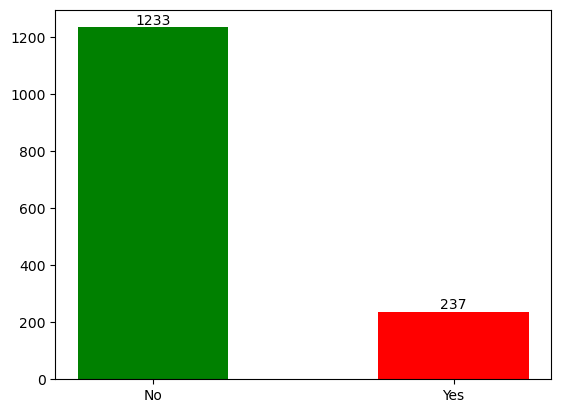

In [22]:
labels, counts = np.unique(df['Attrition'], return_counts=True)
plt.bar(x=labels, height=counts, align='center', width=0.5, color=['green', 'red'])

for i in range(len(labels)):
    plt.text(i, counts[i], counts[i], ha='center', va='bottom')

In [23]:
df_attr = df[df['Attrition']=='Yes']
df_ret = df[df['Attrition']=='No']

In [24]:
df_attr.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,237.0,33.607595,9.689350,18.0,28.0,32.0,39.0,58.0
Attrition_num,237.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
DailyRate,237.0,750.362869,401.899519,103.0,408.0,699.0,1092.0,1496.0
DistanceFromHome,237.0,10.632911,8.452525,1.0,3.0,9.0,17.0,29.0
Education,237.0,2.839662,1.008244,1.0,2.0,3.0,4.0,5.0
EnvironmentSatisfaction,237.0,2.464135,1.169791,1.0,1.0,3.0,4.0,4.0
HourlyRate,237.0,65.573840,20.099958,31.0,50.0,66.0,84.0,100.0
JobInvolvement,237.0,2.518987,0.773405,1.0,2.0,3.0,3.0,4.0
JobLevel,237.0,1.637131,0.940594,1.0,1.0,1.0,2.0,5.0
JobSatisfaction,237.0,2.468354,1.118058,1.0,1.0,3.0,3.0,4.0


In [25]:
df_ret.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1233.0,37.561233,8.888360,18.0,31.0,36.0,43.0,60.0
Attrition_num,1233.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
DailyRate,1233.0,812.504461,403.208379,102.0,477.0,817.0,1176.0,1499.0
DistanceFromHome,1233.0,8.903356,8.008315,1.0,2.0,7.0,13.0,29.0
Education,1233.0,2.927007,1.027002,1.0,2.0,3.0,4.0,5.0
EnvironmentSatisfaction,1233.0,2.771290,1.071132,1.0,2.0,3.0,4.0,4.0
HourlyRate,1233.0,65.977006,20.368502,30.0,48.0,66.0,83.0,100.0
JobInvolvement,1233.0,2.770479,0.692050,1.0,2.0,3.0,3.0,4.0
JobLevel,1233.0,2.145985,1.117933,1.0,1.0,2.0,3.0,5.0
JobSatisfaction,1233.0,2.778589,1.093277,1.0,2.0,3.0,4.0,4.0


- Dataframe has been split into individuals with and without attrition (retained)
- Individuals with attrition are younger, live further away from the workplace, are less educated, have less satisfication (environment, Job, Relationship), lower job Involvement and Job Level, have lower monthly income, work at more companies, have lower stock option, less total working years, less training time, poorer work-life balance level, fewer years at the company than employees without attrition.

- Interestingly, on average, the % salary hike and the performance rating between the two groups is very similar.

- Employees with retention have less years in their current role, less years since their last promotion and less years with their current managers.

This will be investigated this further

## 2)a) Correlation Analysis

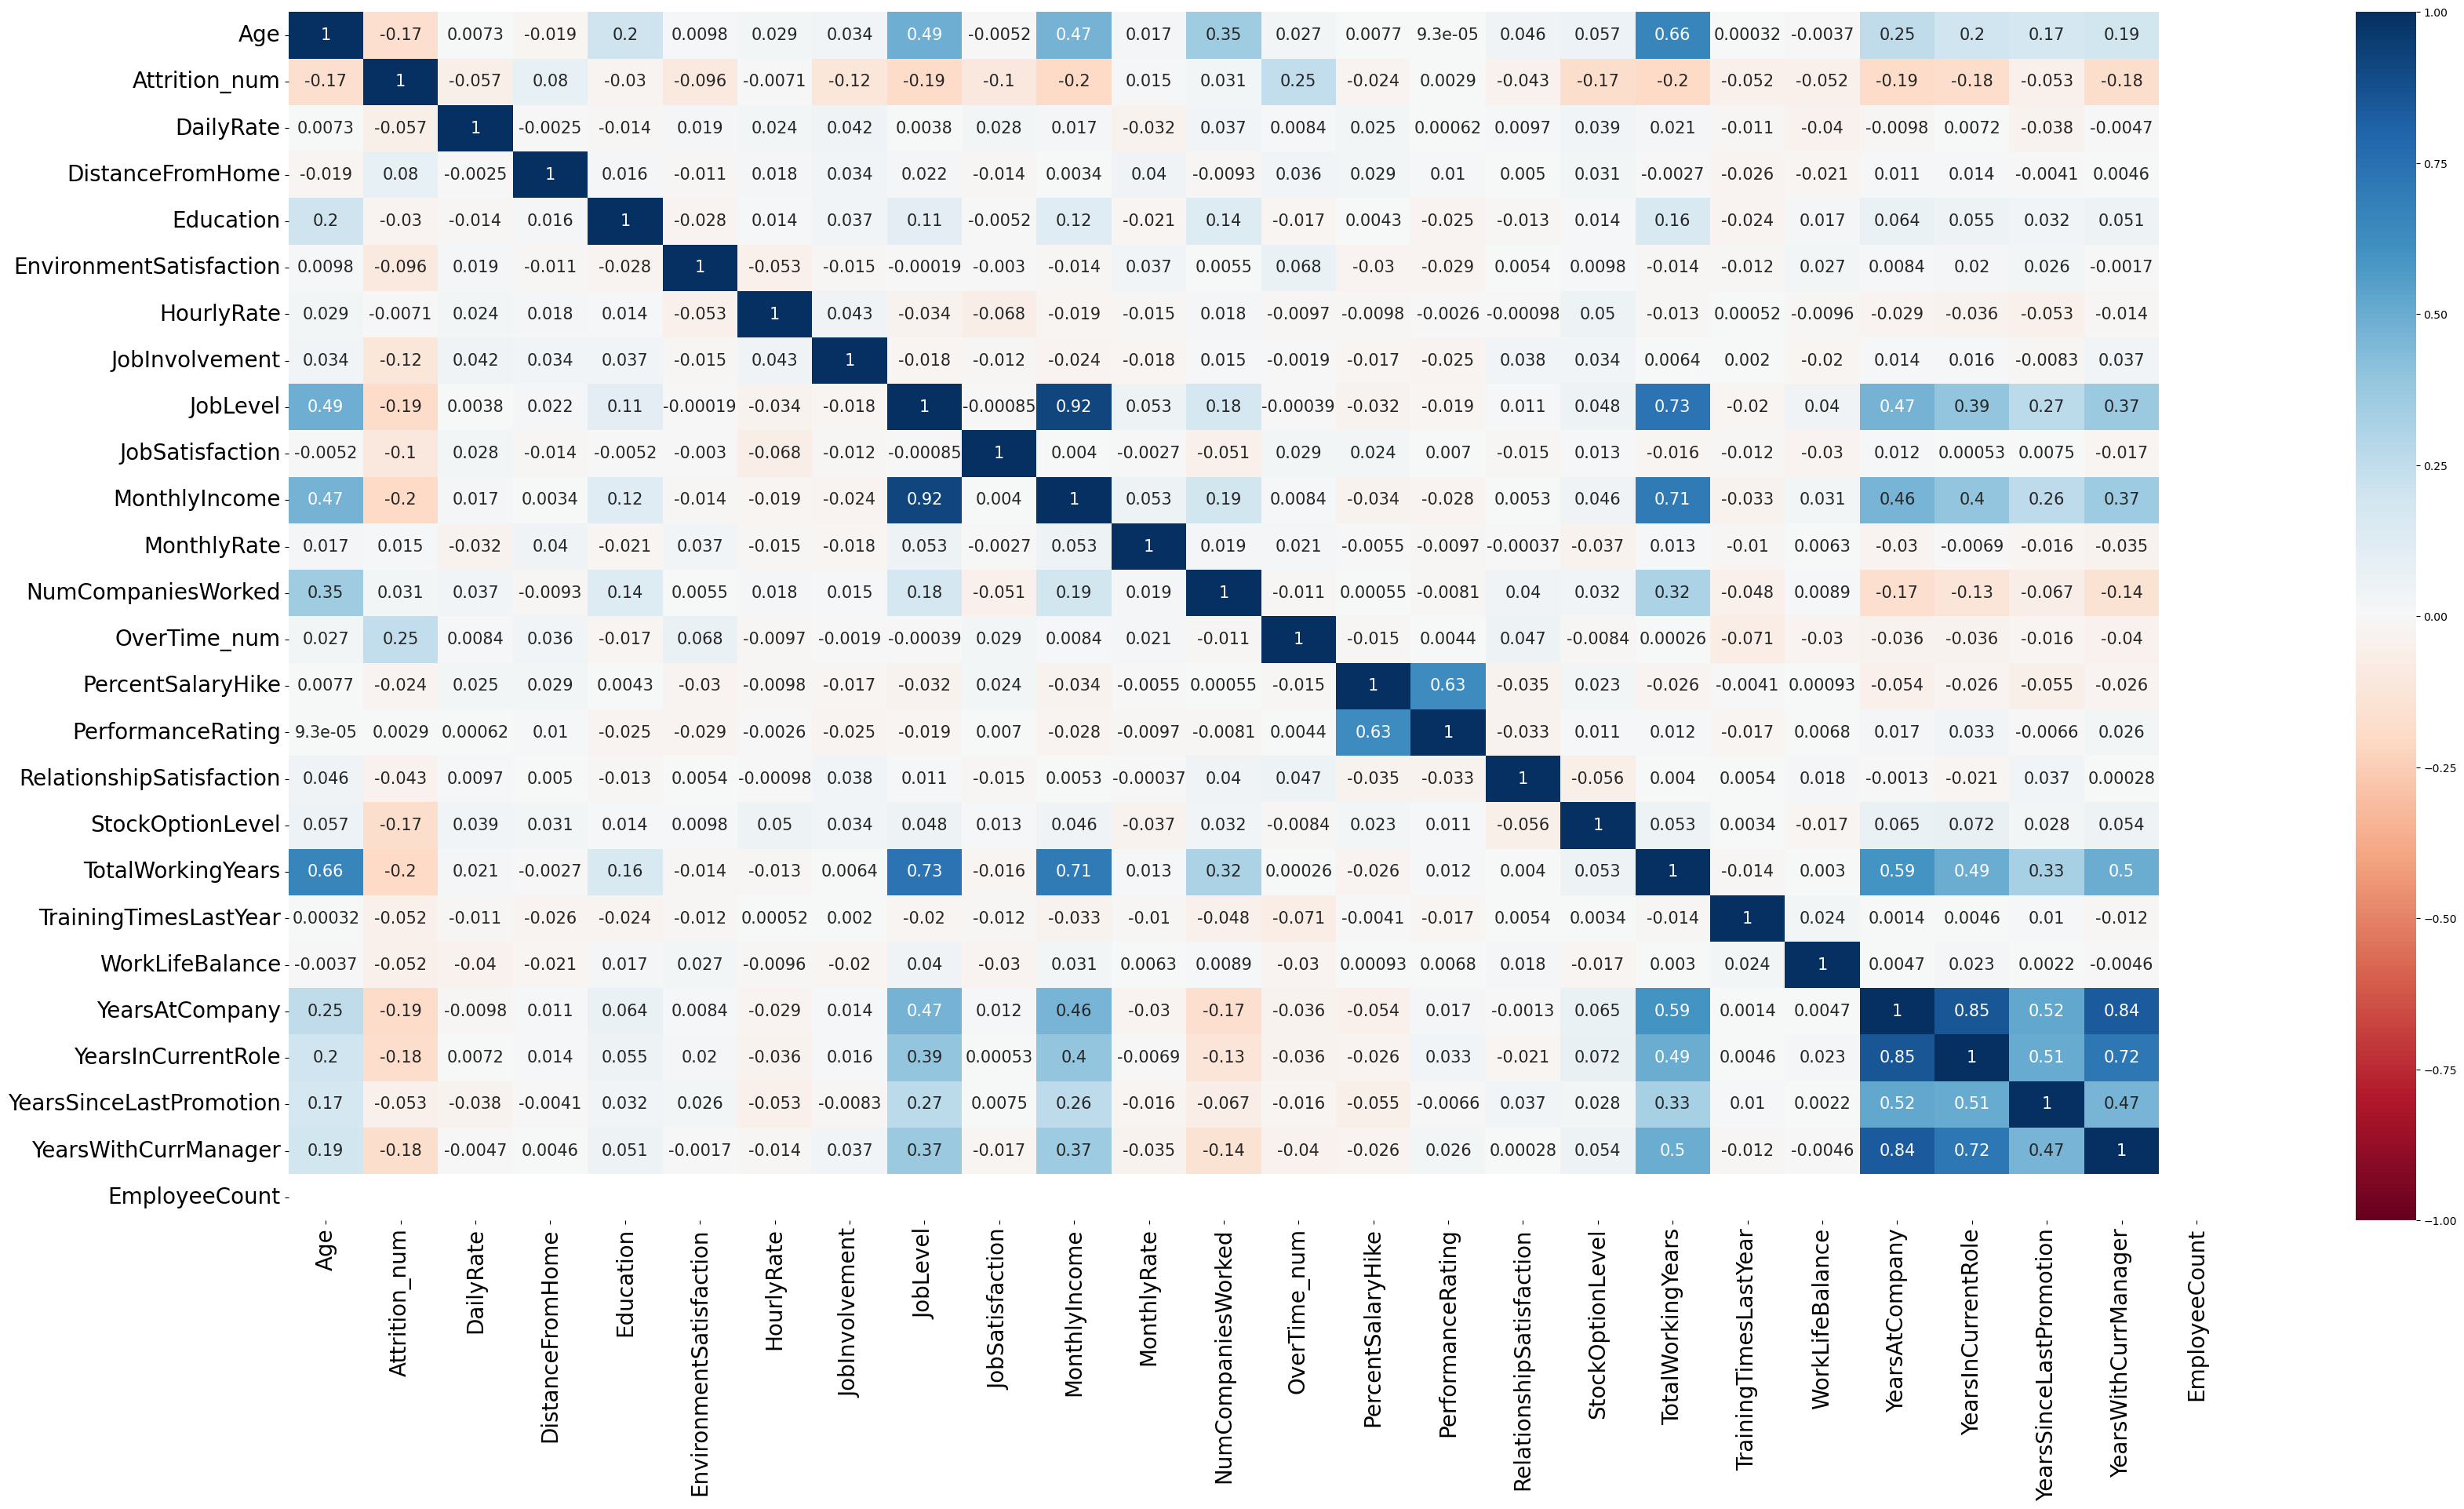

In [27]:
plt.figure(figsize =(40,20))
ax=sns.heatmap(df.corr(method='spearman'), annot = True, cmap = 'RdBu', annot_kws={'size':15}, vmin=-1, vmax=1)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
plt.show()

- From the correlation heatmap, we can observe how different features correlate with eachother. The spearman correlation value was chosen as it was not assumed that the features have a linear relationship with eachother. 

- We can observe correlations that make sense e.g. the Spearnman value of 0.92 for Monthly Income and and Job Level as one would expect to be paid more at higher Job Levels.

- The numerical attrition column, Attrition_num, which is our feature of interest does not exhibit any significant correlation with any features. The strongest feature seems to be 'Overtime_num'. This will have to be investigated further.

## 2)b) Job roles and attrition

Department: Sales , Role: Sales Executive , Attrition Percent 17.484662576687114
Department: Sales , Role: Sales Representative , Attrition Percent 39.75903614457831
Department: Sales , Role: Manager , Attrition Percent 5.405405405405405


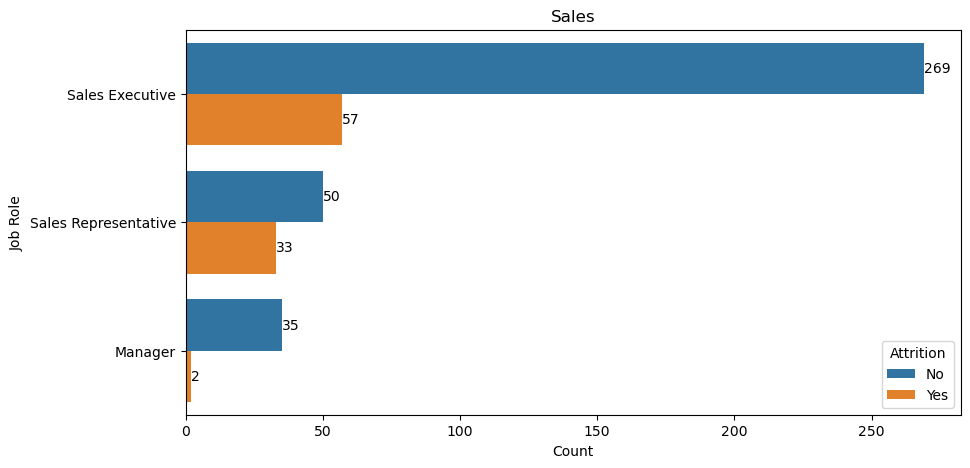

Department: Human Resources , Role: Human Resources , Attrition Percent 23.076923076923077
Department: Human Resources , Role: Manager , Attrition Percent 0.0


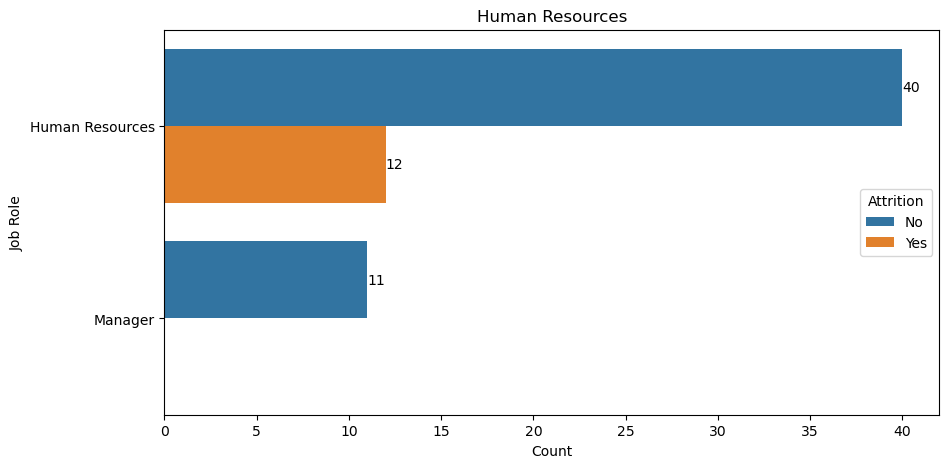

Department: Research & Development , Role: Research Scientist , Attrition Percent 16.095890410958905
Department: Research & Development , Role: Laboratory Technician , Attrition Percent 23.93822393822394
Department: Research & Development , Role: Manufacturing Director , Attrition Percent 6.896551724137931
Department: Research & Development , Role: Healthcare Representative , Attrition Percent 6.870229007633588
Department: Research & Development , Role: Research Director , Attrition Percent 2.5
Department: Research & Development , Role: Manager , Attrition Percent 5.555555555555555


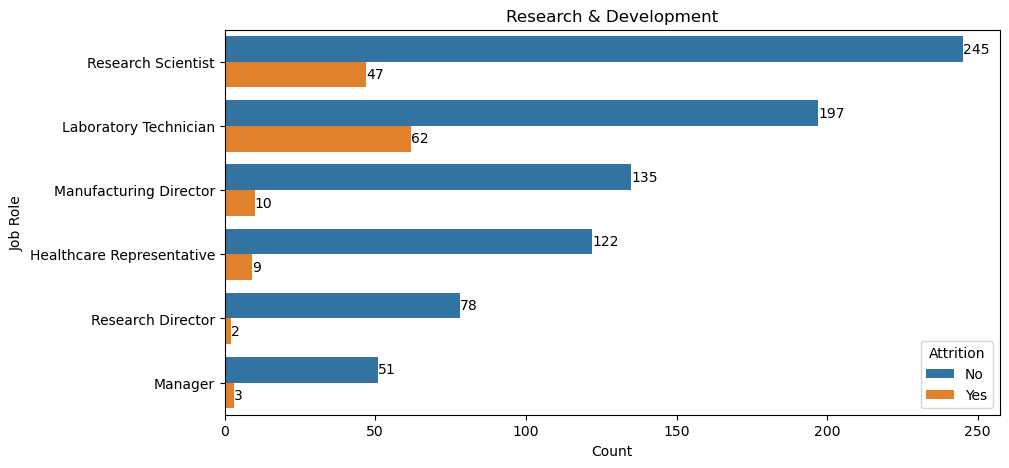

In [28]:
department_df = df.groupby(['Attrition', 'Department', 'JobRole' ])['EmployeeCount'].count().reset_index()

# Create a separate dataframe for each department
departments = list(set(department_df["Department"]))
for department in departments:
    dep_df = department_df[department_df["Department"] == department]
    dep_df = dep_df.sort_values("EmployeeCount", ascending=False)
    # create the horizontal bar plot
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=dep_df["EmployeeCount"],y=dep_df["JobRole"], hue=dep_df["Attrition"], orient='h')
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    values = [i.get_width() for i in ax.patches]
   # job_role = list(set(dep_df['JobRole'].tolist()))
    for j in dep_df['JobRole'].unique():
        try:
            x = dep_df[(dep_df['JobRole']==j) & (dep_df['Attrition']=='Yes')]['EmployeeCount'].values[0]
        except IndexError:
            x =0
        y = dep_df[(dep_df['JobRole']==j) & (dep_df['Attrition']=='No')]['EmployeeCount'].values[0]
        print('Department:',department, ', Role:',j, ', Attrition Percent', (x/(x+y))*100)
    plt.title(f"{department}")
    plt.xlabel("Count")
    plt.ylabel("Job Role")
    plt.show()

- The Sales Representatives have the highest attrition rate at almost 40% and Sales Executives have a fairly significant attrition rate at arround 17.5%. 

- Research Scientists and Labratory Technicians have significant rates of around 16.1% and 23.9% respectively. 

- The Human Resources role from the Human Resources department has a significant attrrition rate at around 23.1%

- Regardless of department, we find that those in senior roles such as Managers or Directors have relatively low atrition rates.

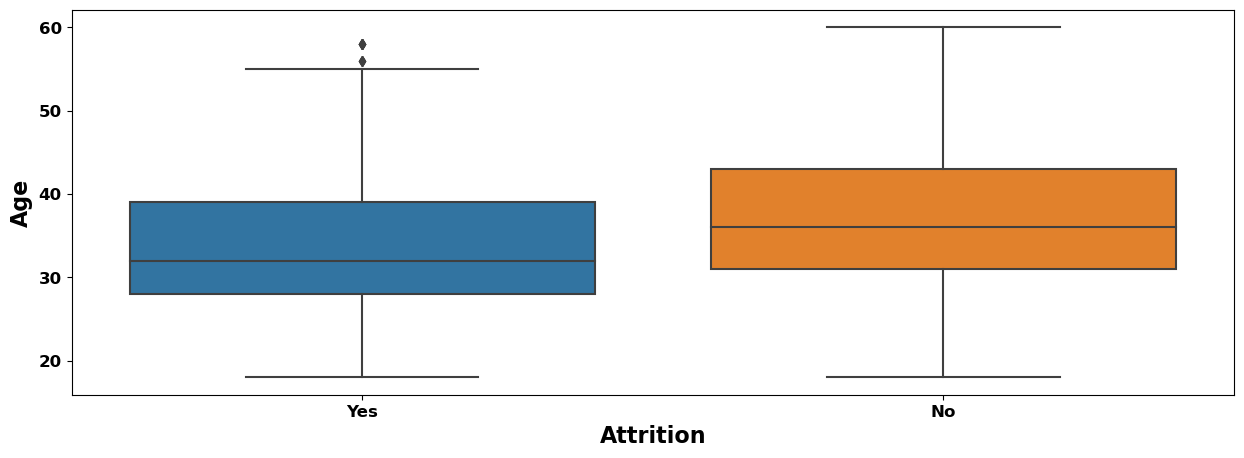

In [29]:
plt.figure(figsize =(15,5))
ax = sns.boxplot(x='Attrition', y='Age', data=df)
ax.set_xlabel('Attrition', fontsize=16, fontweight='bold')
ax.set_ylabel('Age', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- We find that the median age of individuals with attrition is lower than those without

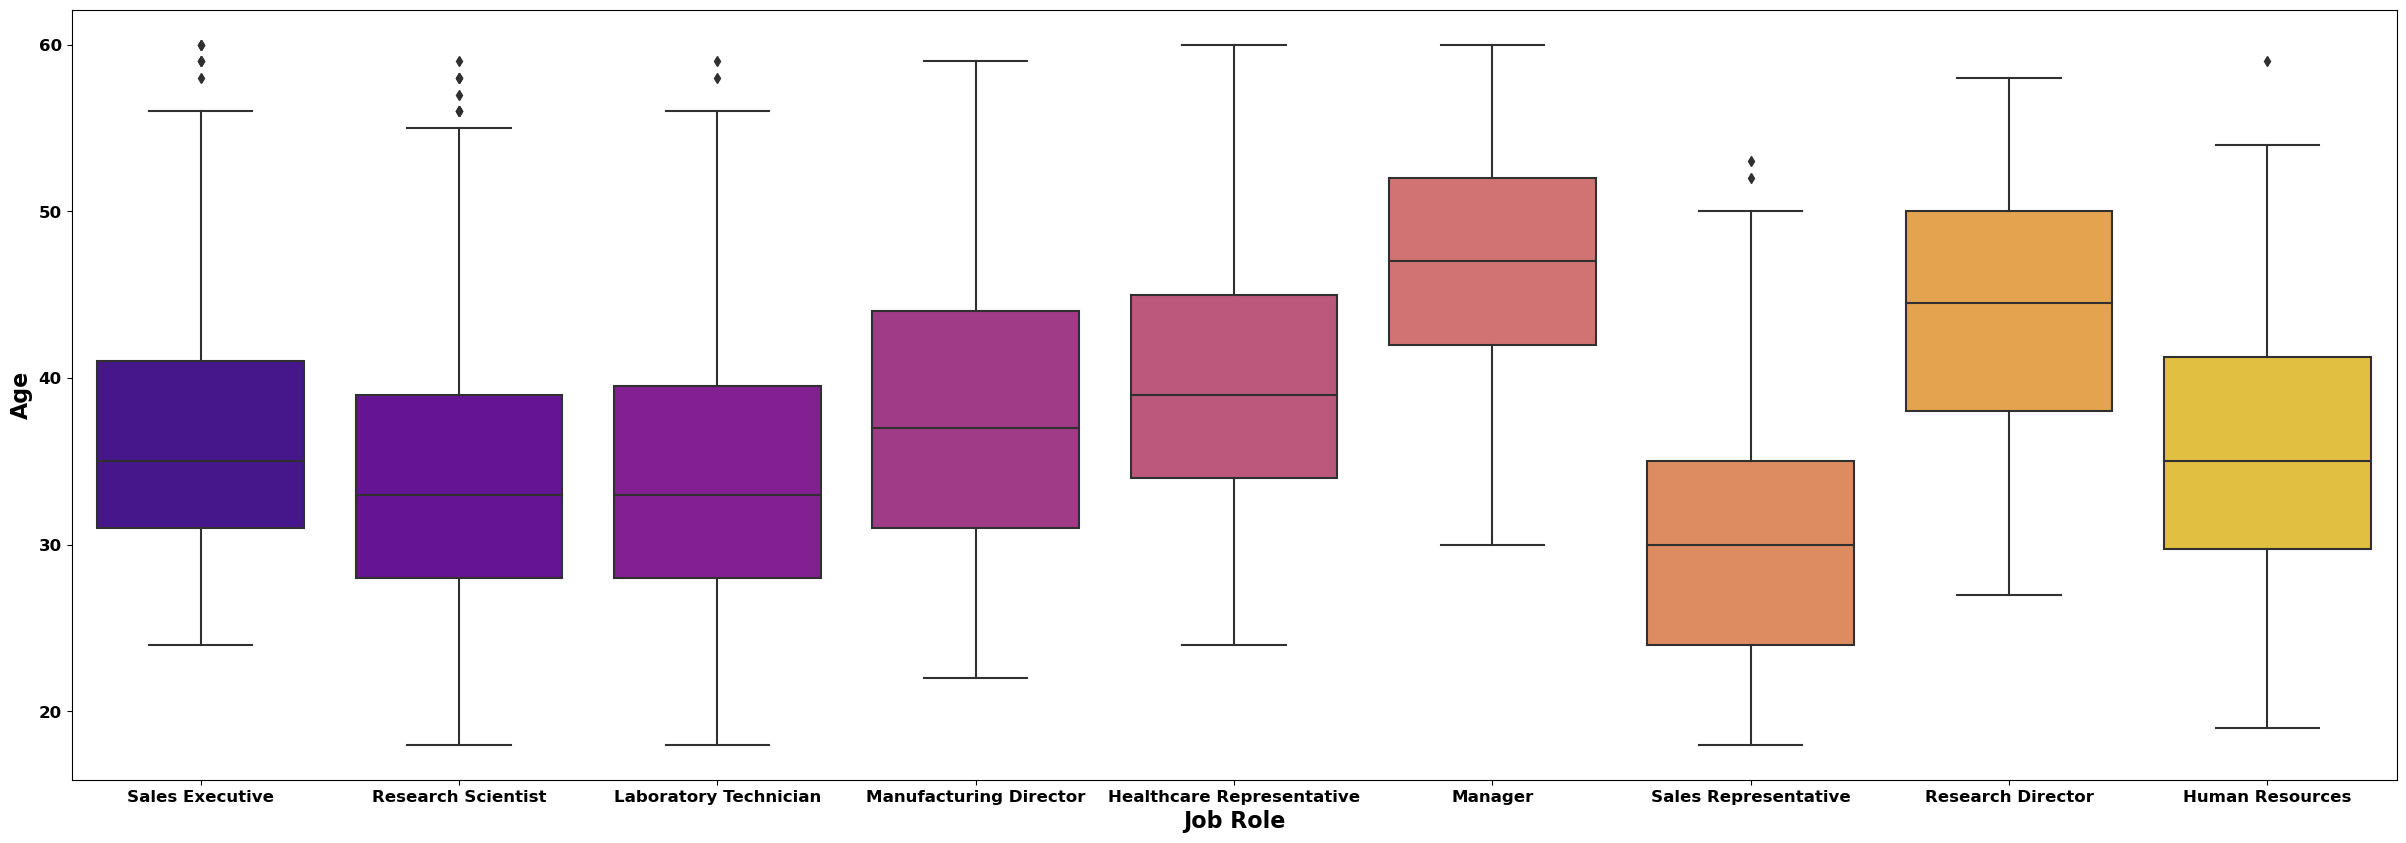

In [30]:
plt.figure(figsize =(30,10))
ax = sns.boxplot(x='JobRole', y='Age', data=df, palette='plasma')
ax.set_xlabel('Job Role', fontsize=16, fontweight='bold')
ax.set_ylabel('Age', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- We find that the roles in which individuals are the youngest in belong to the Sales Representatives, Sales Executives, Research Scientists, Labratory Technicians and Human Resources job roles. These were also the roles with the highest attrition rates.
- Managers and Directors have older median ages

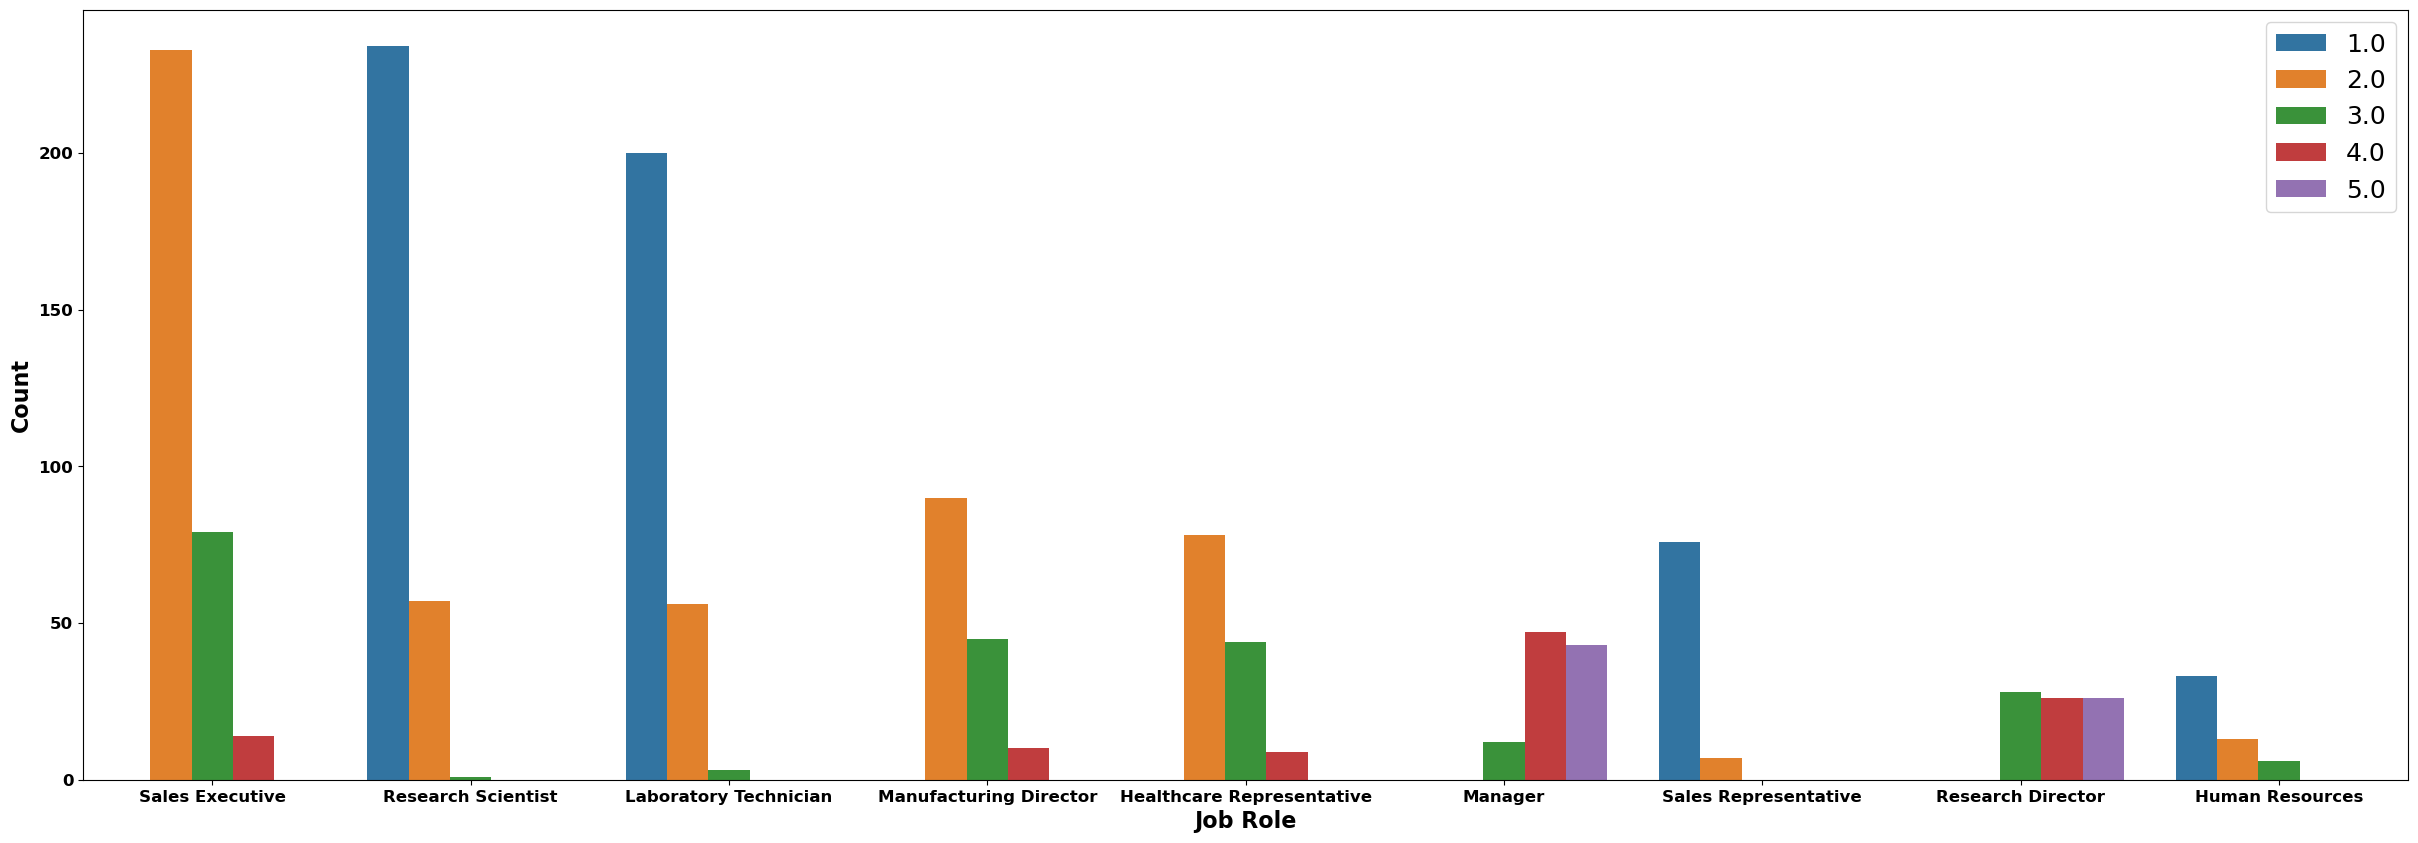

In [31]:
plt.figure(figsize =(30,10))
ax = sns.countplot(x="JobRole", hue="JobLevel", data=df)
ax.set_xlabel('Job Role', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.legend( fontsize=18)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- We also find that most individuals in the roles with high attrition, have low job levels, especially Sales Representatives

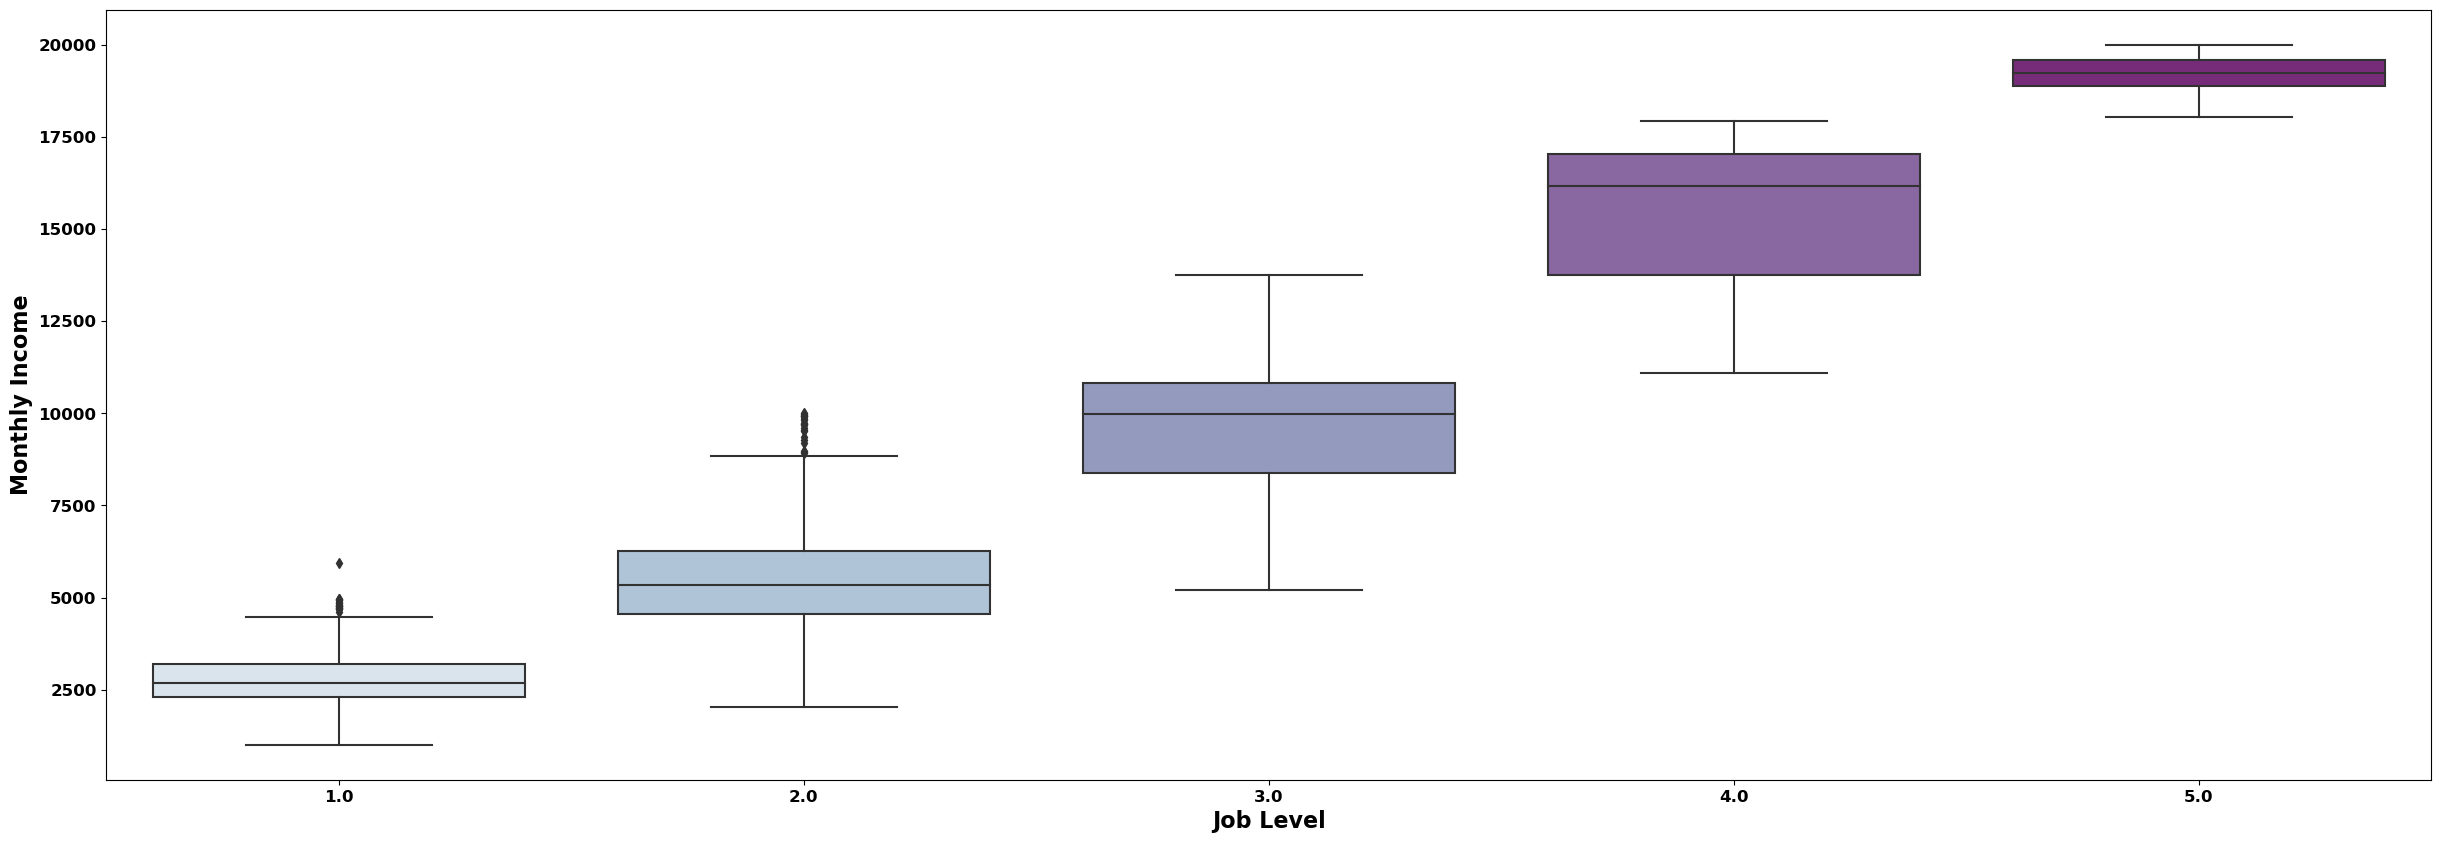

In [32]:
plt.figure(figsize =(30,10))
ax = sns.boxplot(x='JobLevel', y='MonthlyIncome', data=df, palette='BuPu')
ax.set_xlabel('Job Level', fontsize=16, fontweight='bold')
ax.set_ylabel('Monthly Income', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- Monthly income increases as Job Level increases
- the roles with the highest attrition rates mostly consist of individuals in low Job Levels. This means their Monthly Income tends to be lower too

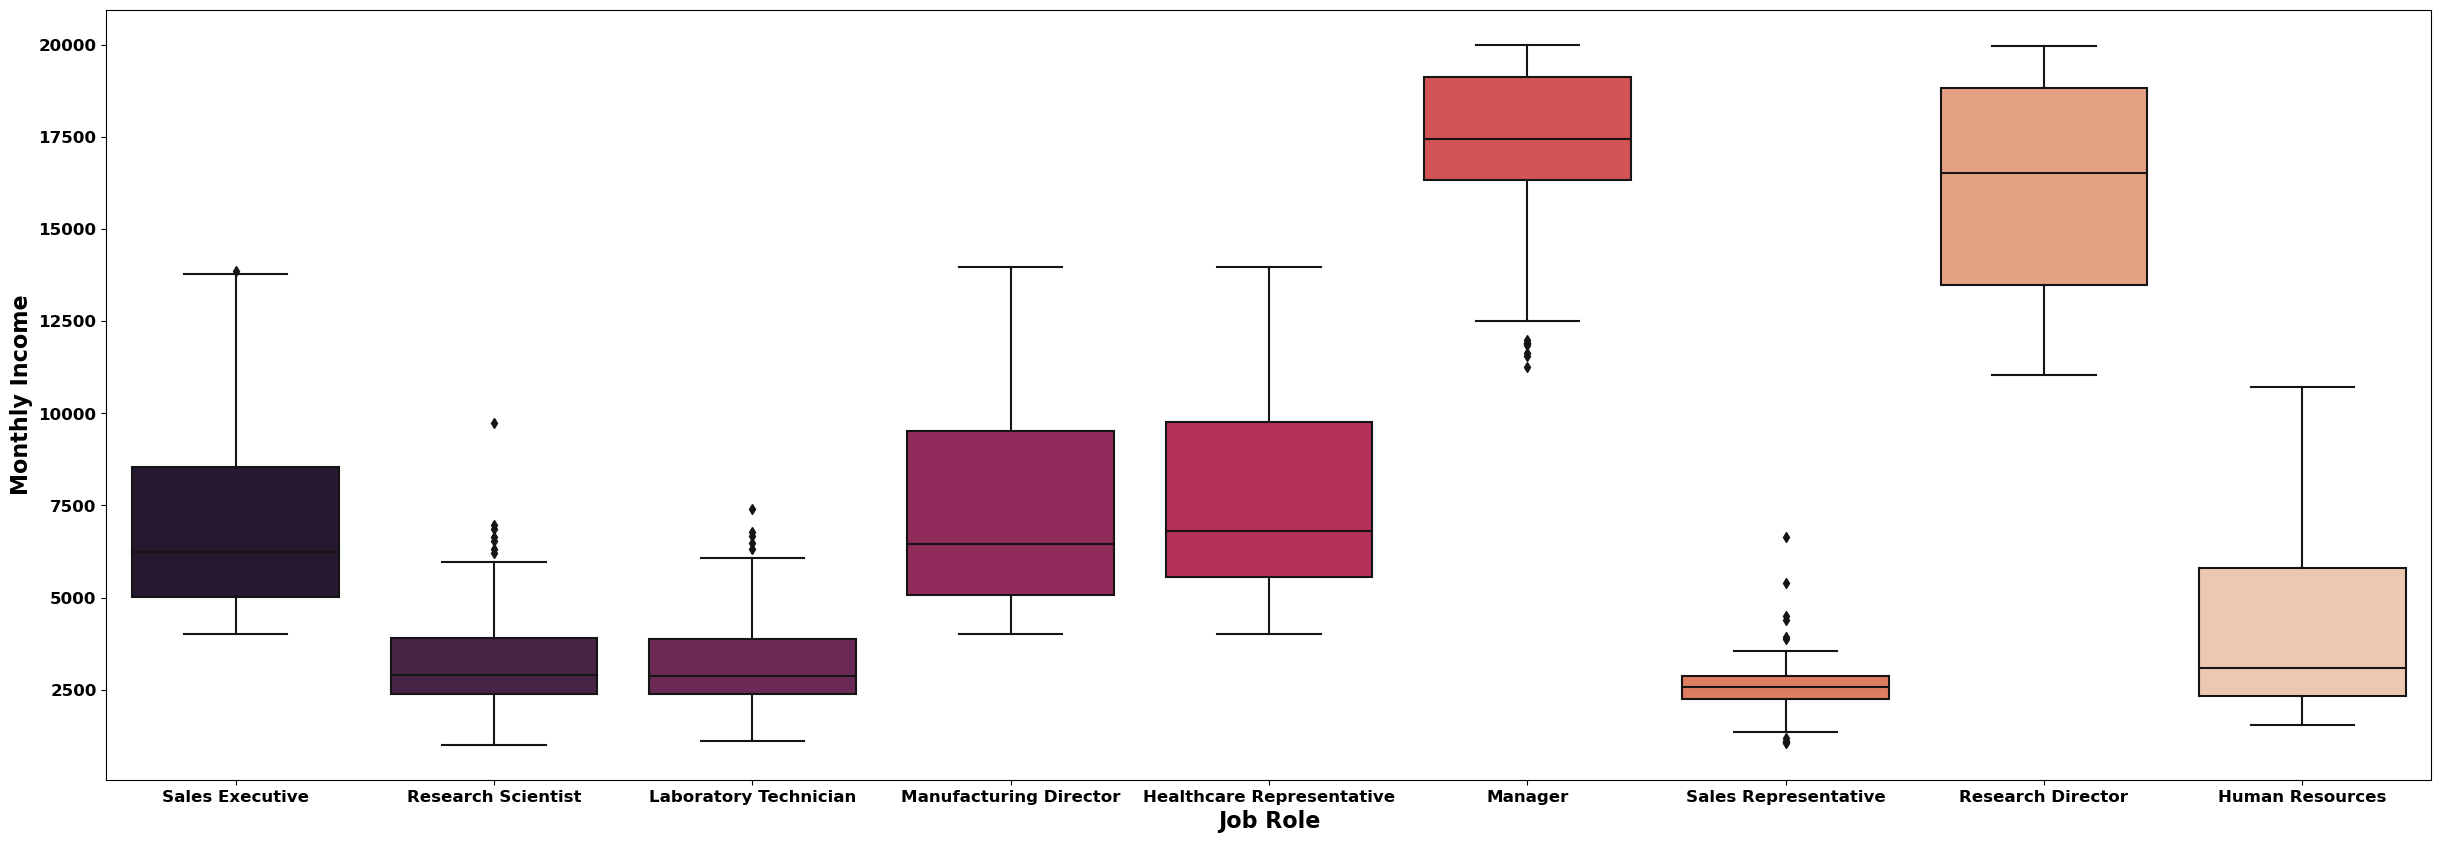

In [33]:
plt.figure(figsize =(30,10))
ax = sns.boxplot(x='JobRole', y='MonthlyIncome', data=df, palette='rocket')
ax.set_xlabel('Job Role', fontsize=16, fontweight='bold')
ax.set_ylabel('Monthly Income', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- The Job roles with the highest attrition (i.e. Sales Representatives, Sales Executives, Research Scientists, Labratory Technicians and Human Resources) are the groups with the lowest median monthly income.

- Furthermore, interquartile range represented by the height of the boxplot for these groups is very small showing that salary progression in these roles is very limited. 

- Managers and directors are the highest earners

## 2)d) satisfaction metrics, work life balance and job involvement with respect to Job Role

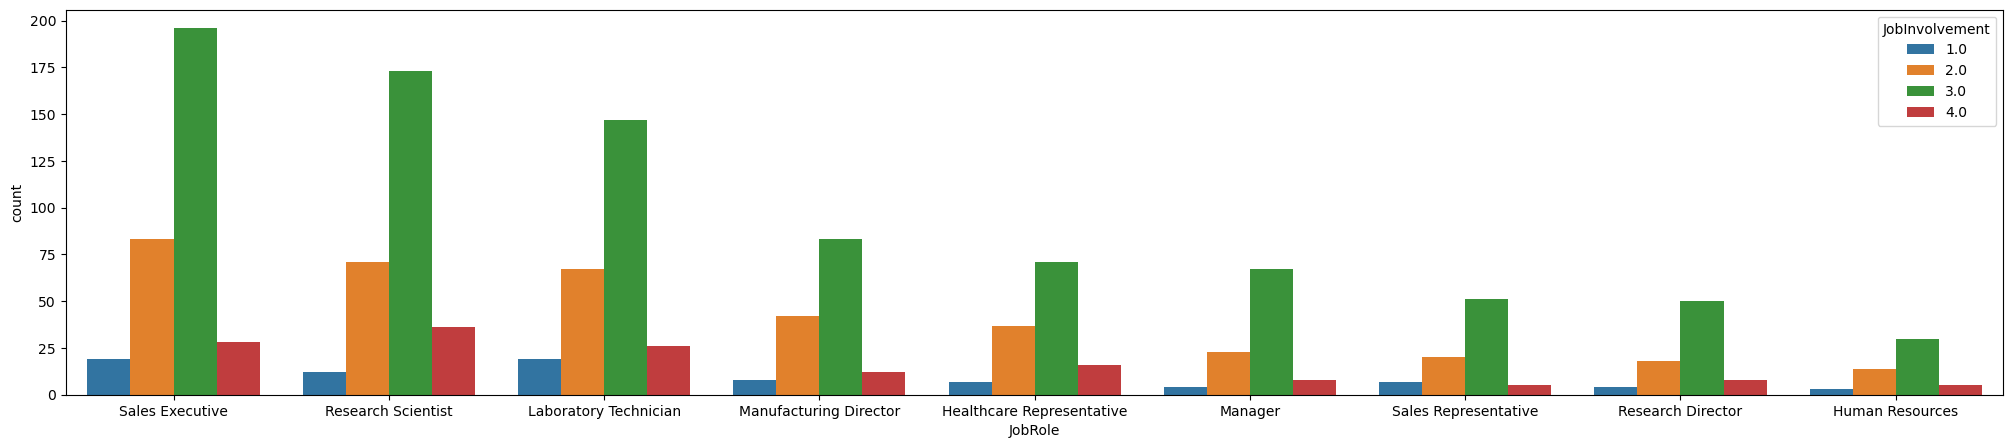

In [34]:
plt.figure(figsize =(25, 5))
sns.countplot(x='JobRole', hue='JobInvolvement',  data=df)
plt.show()

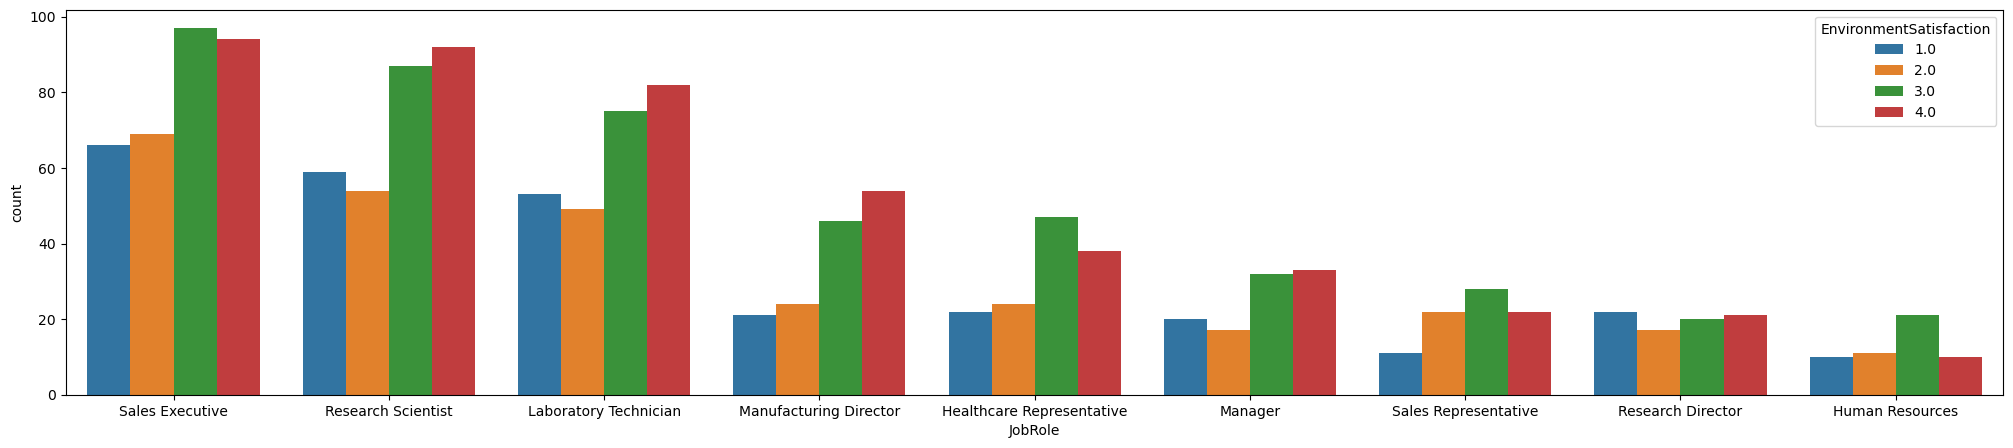

In [35]:
plt.figure(figsize =(25, 5))
sns.countplot(x='JobRole', hue='EnvironmentSatisfaction',  data=df)
plt.show()

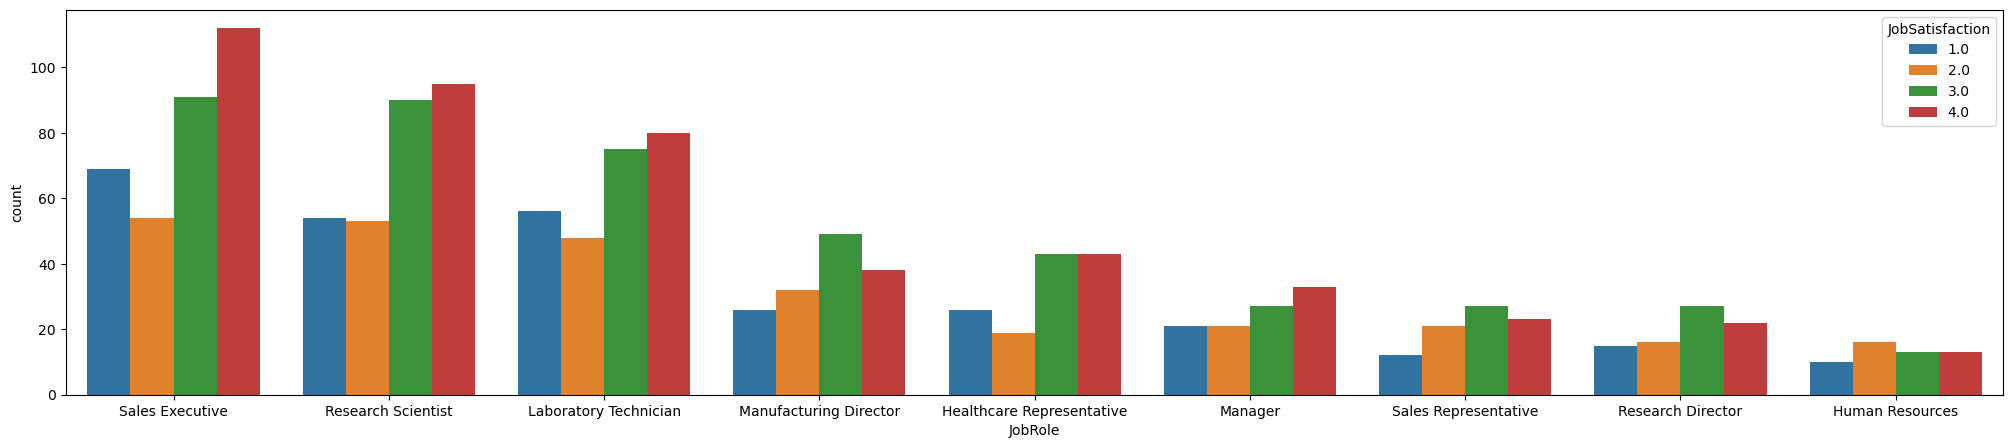

In [36]:
plt.figure(figsize =(25, 5))
sns.countplot(x='JobRole', hue='JobSatisfaction',  data=df)
plt.show()

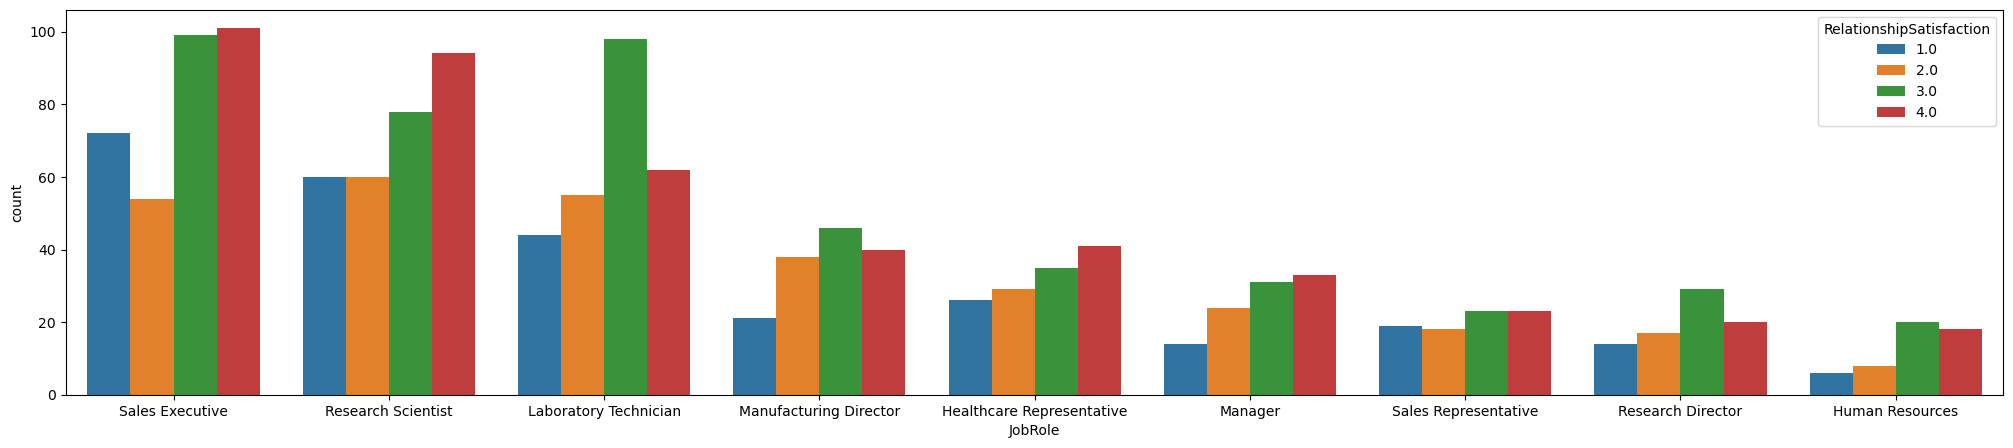

In [37]:
plt.figure(figsize =(25, 5))
sns.countplot(x='JobRole', hue='RelationshipSatisfaction',  data=df)
plt.show()

- In terms of the satisfaction metrics, work life balance and job involvement, we see a recurring theme. If we class a rating of 1 and 2 as low, we find that the highest frequency of low scores are repeatedly found in Sales Executive, Research Scientist, and Labratory Technicians roles. These 3 roles also have significant attrition rates as we saw previously

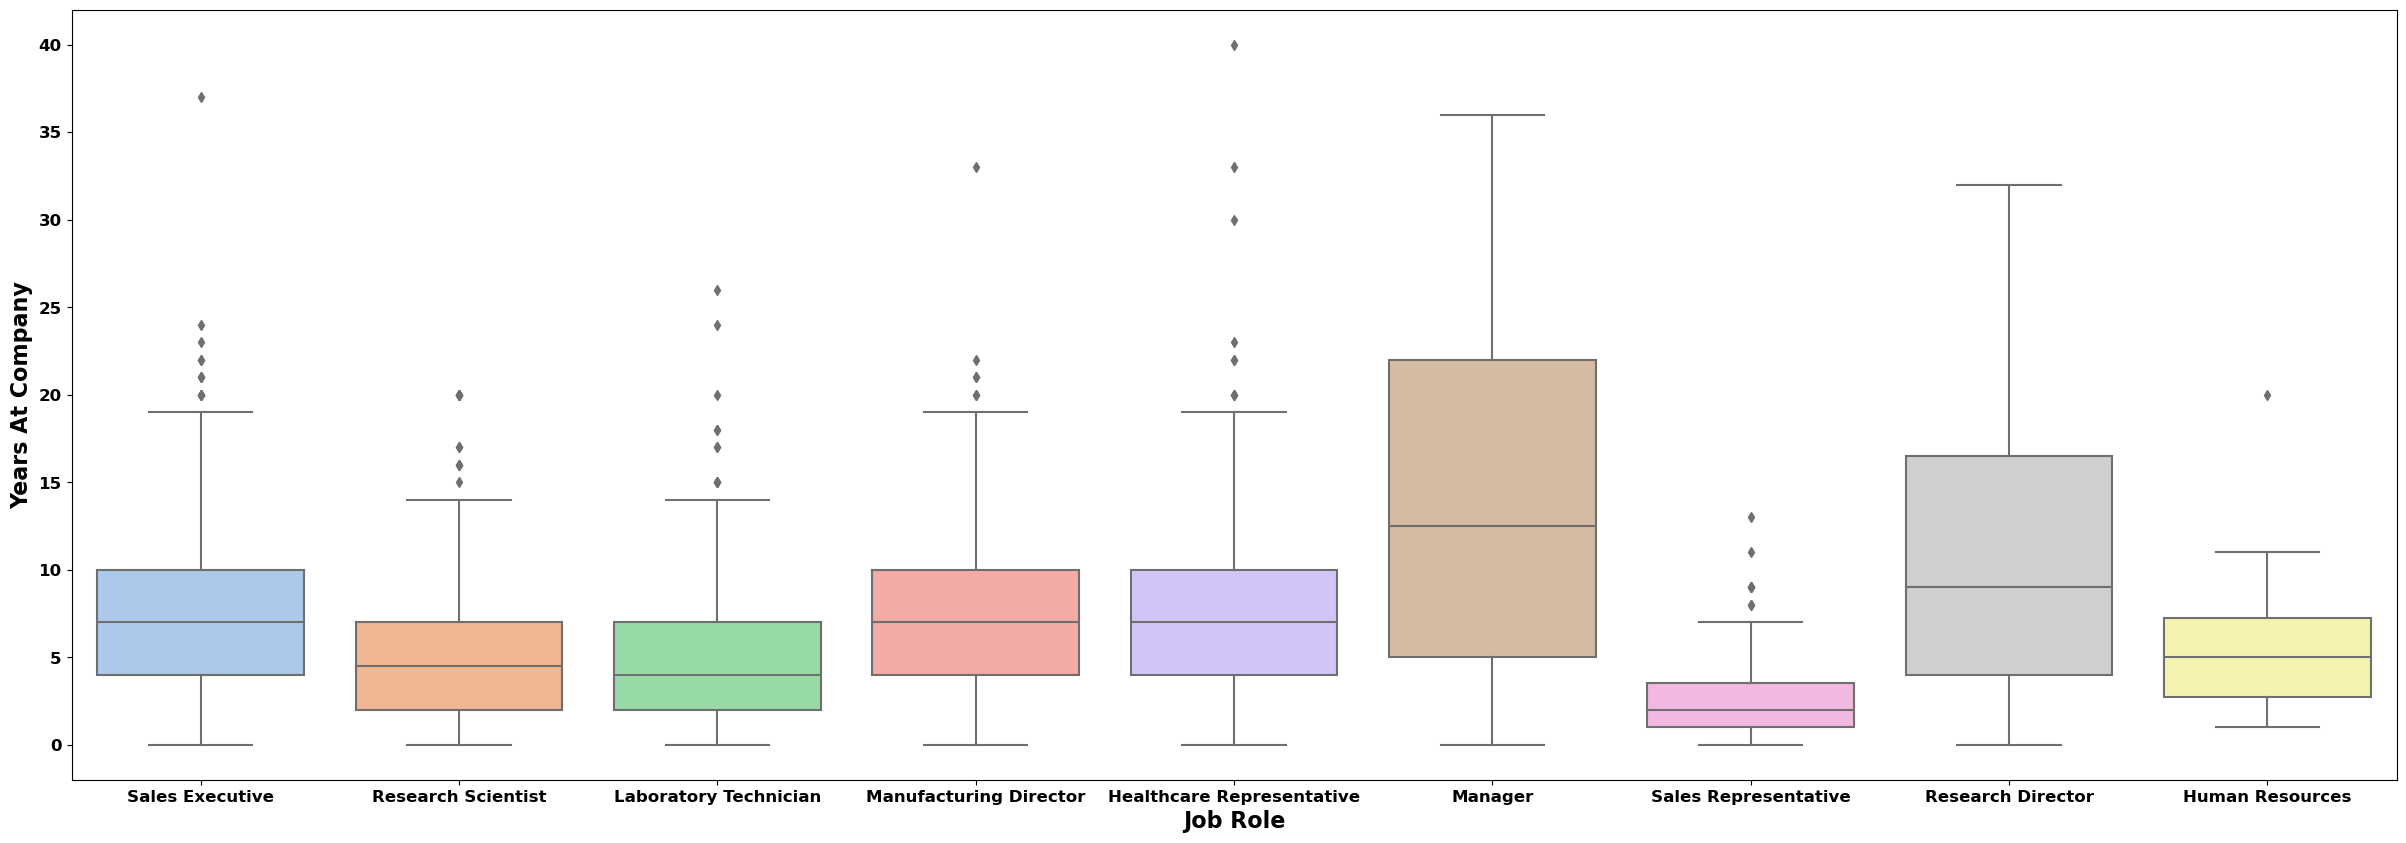

In [38]:
plt.figure(figsize =(30,10))
ax = sns.boxplot(x='JobRole', y='YearsAtCompany', data=df, palette='pastel')
ax.set_xlabel('Job Role', fontsize=16, fontweight='bold')
ax.set_ylabel('Years At Company', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- We find that the individals in roles with the highest attrition do not stay with the company very long . Especially Sales Representatives.

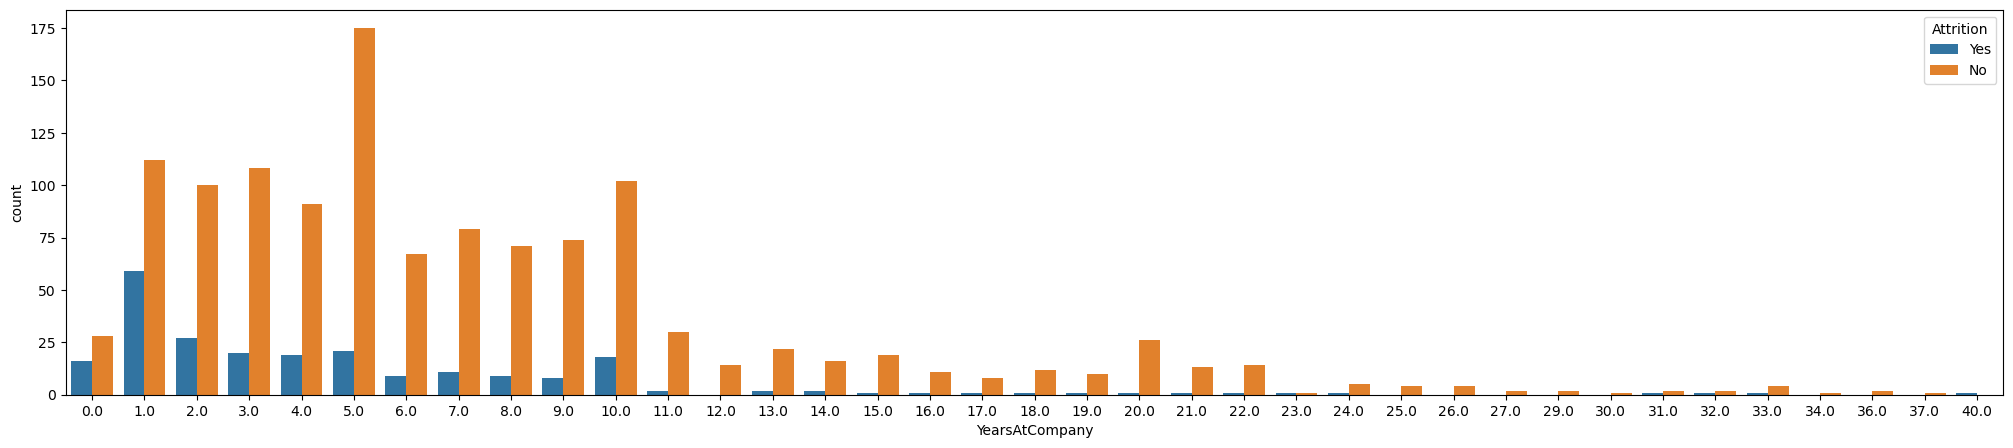

In [36]:
plt.figure(figsize =(25, 5))
sns.countplot(x='YearsAtCompany', hue='Attrition',  data=df)
plt.show()

- Attrition is particularly high after 1 year at the company. There should be an employee retention strategy to retain these high risk employees

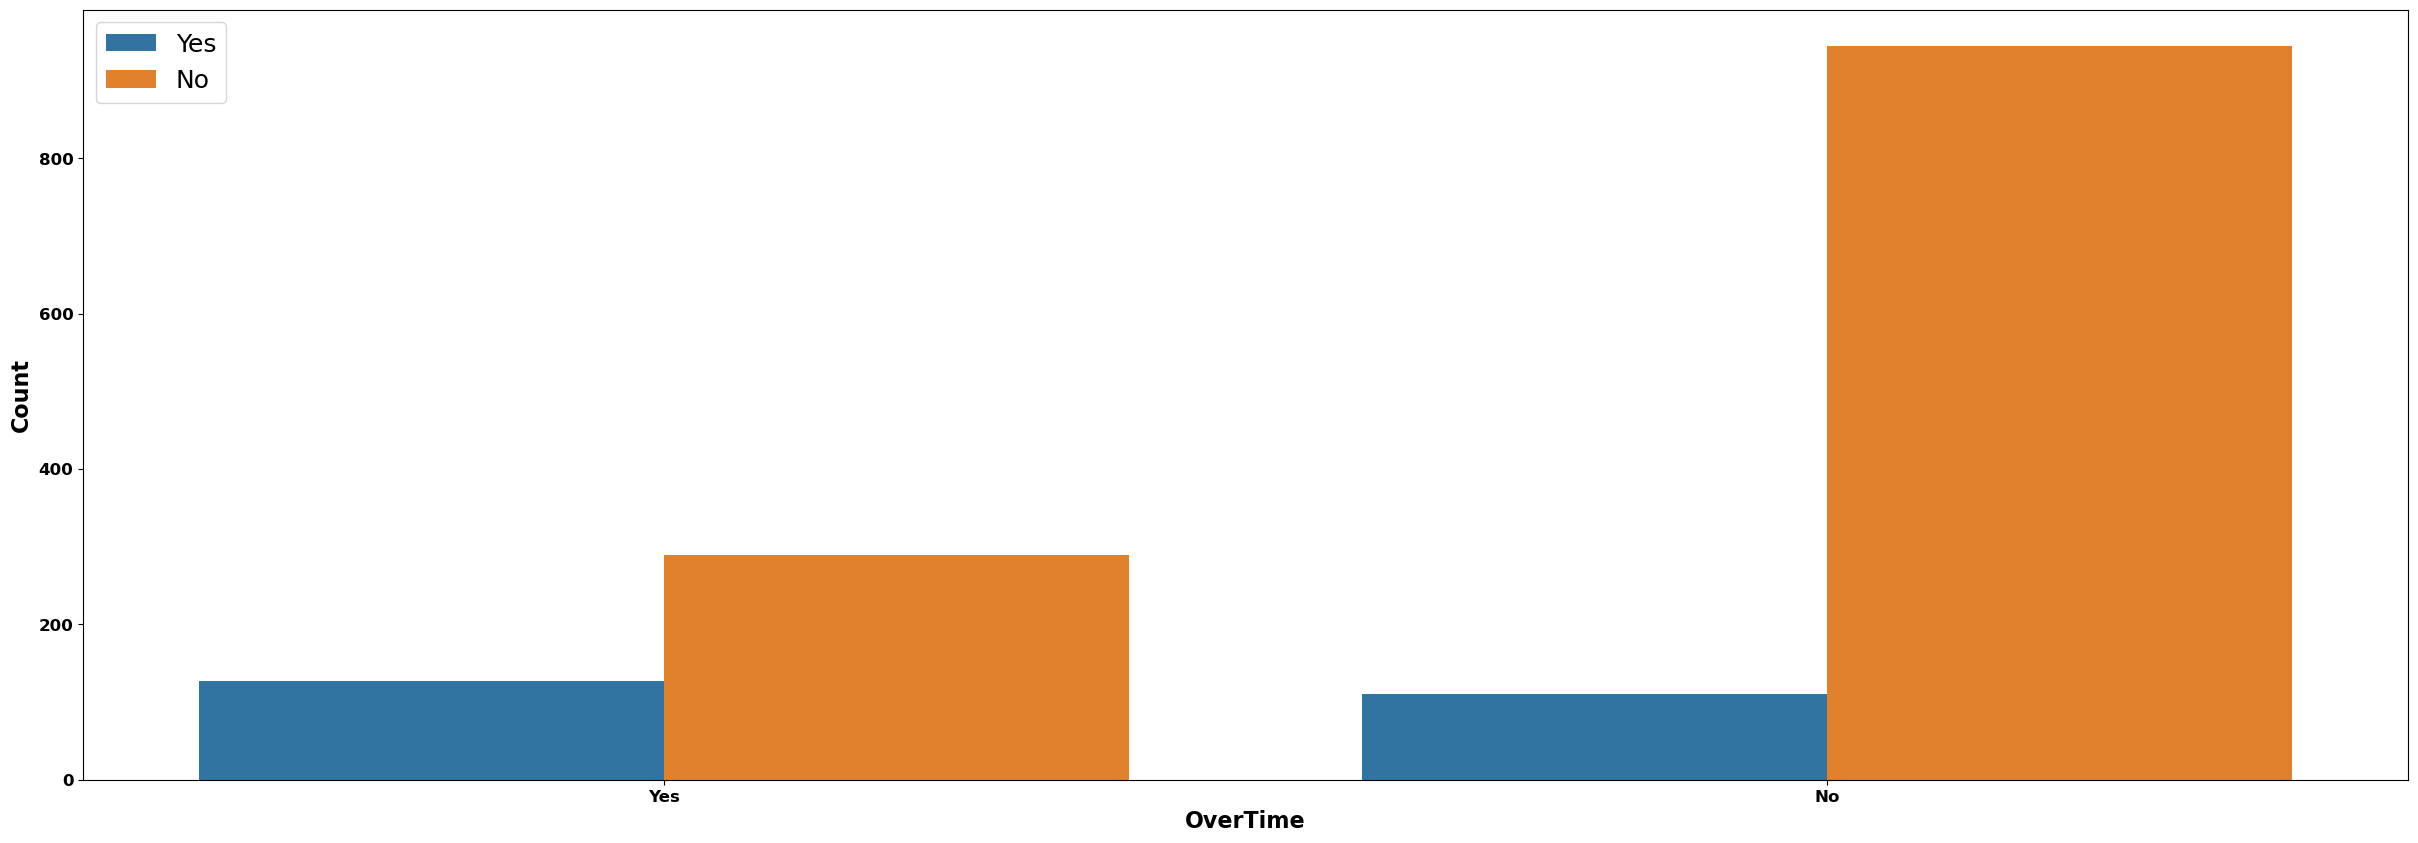

In [41]:
plt.figure(figsize =(30,10))
ax = sns.countplot(x="OverTime", hue="Attrition", data=df)
ax.set_xlabel('OverTime', fontsize=16, fontweight='bold')
ax.set_ylabel('Count', fontsize=16, fontweight='bold')
ax.legend( fontsize=18)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

- a much higher proportion of people who do overtime experience attrition compared to those who do not